In [1]:
import torch
print(torch.__version__)

import torch.nn as nn

import torchvision
import torchvision.transforms.functional as TF
from torchvision import datasets

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from models import AutoEncoder
from tqdm.auto import tqdm, trange

import numpy as np
import seaborn as sns
sns.set()

import pandas as pd
import imageio

1.7.0


In [2]:
mnist_trainset = datasets.MNIST(root="../data/", train=True,
                                download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ]))

mnist_valid = datasets.MNIST(root="../data/", train=False,
                             download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ]))

In [41]:
model = AutoEncoder().to("cuda")
loss_fn = nn.MSELoss().to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=1, shuffle=False)

In [42]:
for epoch in range(10):

    train_loss = 0
    valid_loss = 0

    model.train()
    for images, labels in tqdm(dataloader, leave=False):
        optimizer.zero_grad()
        output = model(images.to("cuda"))
        loss = loss_fn(output, images.to("cuda"))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / len(dataloader)

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, leave=False):
            output = model(images.to("cuda"))
            loss = loss_fn(output, images.to("cuda"))
            valid_loss += loss.item() / len(valid_loader)

    print(f"Epoch {epoch+1}: train_loss {train_loss}, valid_loss {valid_loss}")

Epoch 1: train_loss 0.6103099672906187, valid_loss 0.5275896685138334
Epoch 2: train_loss 0.5150771109915491, valid_loss 0.4969452099241311
Epoch 3: train_loss 0.4898832176667031, valid_loss 0.47865951620750047
Epoch 4: train_loss 0.47026872571343287, valid_loss 0.4594475957185059
Epoch 5: train_loss 0.4543027213133219, valid_loss 0.4475179564230132
Epoch 6: train_loss 0.44125431045286134, valid_loss 0.4372241488495829
Epoch 7: train_loss 0.4317732370738534, valid_loss 0.43049156589694487
Epoch 8: train_loss 0.4253201642905726, valid_loss 0.4279327460139981
Epoch 9: train_loss 0.4193495970163775, valid_loss 0.4232514183379717
Epoch 10: train_loss 0.4147748326314793, valid_loss 0.4171855689831069


In [43]:
points = []
colors = []
model.eval()
with torch.no_grad():
    for images, labels in tqdm(valid_loader):
        output = model.encoder(images.to("cuda"))
        points.append(output.squeeze(0).cpu().detach().numpy())
        colors.append(labels[0].detach().numpy())

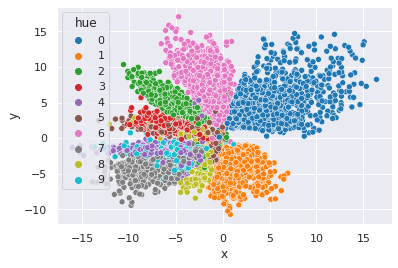

In [44]:
np_points = np.vstack(points)
np_colors = np.stack(colors).tolist()
data = pd.DataFrame({'x': np_points[:,0], 'y': np_points[:,1], 'hue': np_colors})
sns.scatterplot(x='x', y='y', hue='hue', data=data, palette="tab10")
plt.show()

In [45]:
def output_to_pil(output_tensor):
    x = output_tensor.squeeze().cpu().detach().numpy()
    x = (x - np.min(x)) / (np.max(x) - np.min(x)) * 255
    return Image.fromarray(x.astype(np.uint8), mode='L')

In [46]:
pics = []
with torch.no_grad():
    for i in trange(0, 360, 3):
        x = np.sin(np.deg2rad(i))*3
        y = np.cos(np.deg2rad(i))*3
        output = model.decoder(
            torch.Tensor([x, y]).cuda()
        )
        pics.append(output_to_pil(output))

In [47]:
imageio.mimsave("ae_round.gif", pics)

![SegmentLocal](ae_round.gif "segment")